# Выбор локации для скважины

Задача проекта - решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Данные геологоразведки трёх регионов находятся в файлах.
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

Условия задачи:
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

В проекте использованы библиотеки pandas, matplotlib, seaborn, numpy, sklearn. Предсказание строится на одной модели - Линейной регрессии, ключевая метрика - MSE. Для расчёта прибыли в каждом регионе строится отдельная функция, на основании показателей которой происходит итоговый выбор регионе.

## Загрузка и подготовка данных

Импортируем модули, которые нам понадобятся для дальнейшей работы.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sb
import warnings
warnings.simplefilter('ignore')

Читаем базы данных.

In [2]:
df_0 = pd.read_csv('geo_data_0.csv', sep= ',')
display(df_0.head())
df_0.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [3]:
df_1 = pd.read_csv('geo_data_1.csv', sep= ',')
display(df_1.head())
df_1.info()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
df_2 = pd.read_csv('geo_data_2.csv', sep= ',')
display(df_2.head())
df_2.info()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В предоставленных базах по 100 тысяч записей, достаточный массив для построения предсказаний. В каждой базе есть id объекта, для модели данный признак не нужен, но, если мы отберём небольшое количество месторождений в итоге, мы перечислим выбранные скважины по их id. Признаки f0, f1 и f2 - предикторы качества пробы, в переменной product содержится целевой признак.

Мы не будем соединять базы, т.к. нам необходимо работать с каждым регионом отдельно.

Посмотрим на распределения данных визуально.

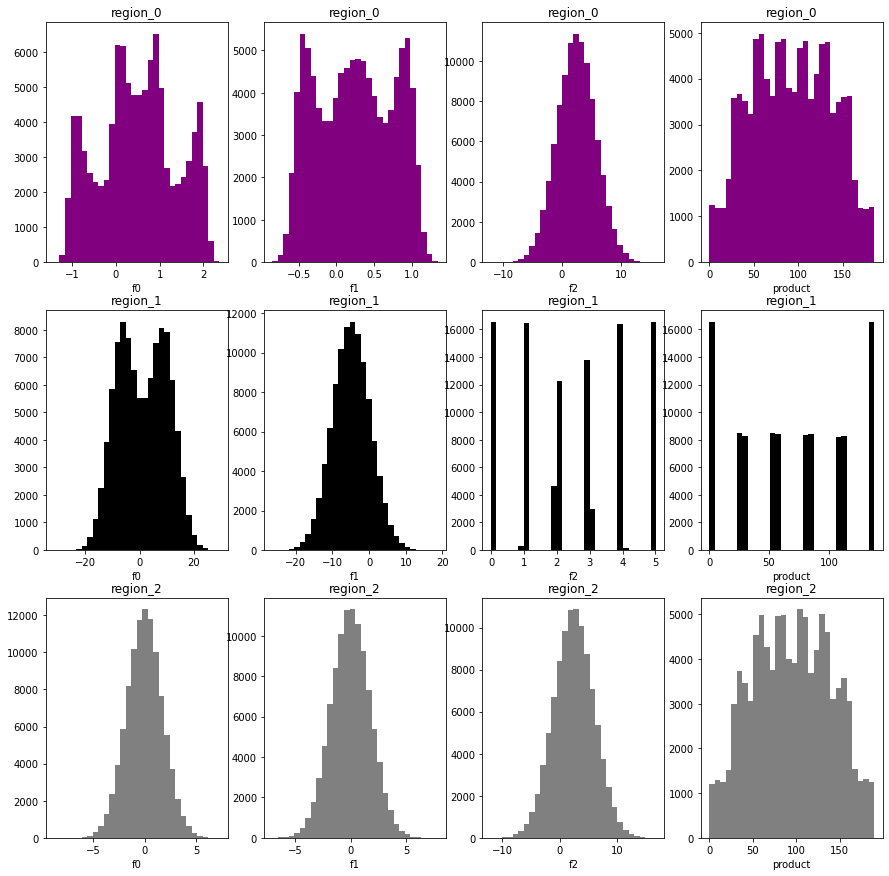

In [5]:
fig, axs = plt.subplots(3, 4, figsize=(15, 15))

list_of_regions = ['region_0', 'region_1', 'region_2']
dfs = [df_0, df_1, df_2]
colors = ['purple', 'black', 'gray']

def draw_plots(i, region:str):
    for j in range(len(list(df_0.columns)[1:])):
        axs[i, j].set_title(region)
        axs[i, j].set_xlabel(list(df_0.columns)[j+1])
        axs[i, j].hist(dfs[i][list(df_0.columns)[j+1]],
                       bins = 30, 
                       color = colors[i])
for k, region in enumerate(list_of_regions):
    draw_plots(k, region)

plt.show()

region_0


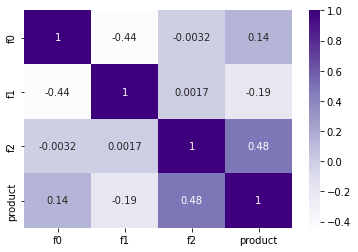

region_1


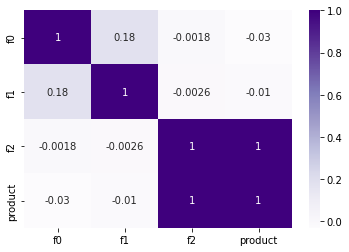

region_2


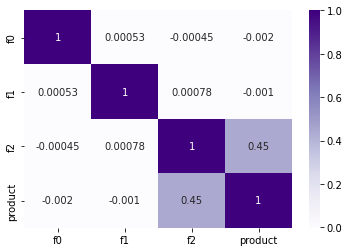

In [6]:
for i, j in zip(dfs, list_of_regions):
    print(j)
    sb.heatmap(i.corr(), cmap="Purples", annot=True)
    plt.show()

Признак F2 имеет достаточно высокую корреляцию с целевым показателем Product. Cтепень корреляции можно считать средней для region_0 и region_2, и крайне высокой - для region_1. Однако это не повод исключать данный фактор, т.к. цель проекта и есть найти способ наилучшим образом предсказывать целевой признак. Если f2 в одиночку делает это наилучшим образом, значит таков будет наш результат.

Если бы у нас был доступ к источнику данных, стоило бы уточнить причины различий распределений признаков, особенно целевого признака, который принимает дискретный характер в region_1, однако на данный момент мы лишь можем принять решение об исключении части данных из анализа на основе имеющейся информации.

Посмотрим на корреляции визуально для выявления нелинейных зависимостей:

region_0


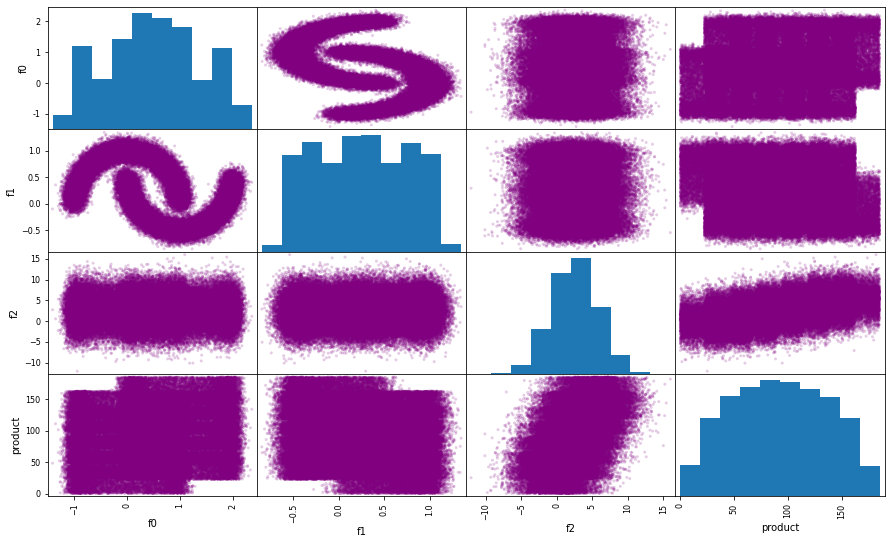

region_1


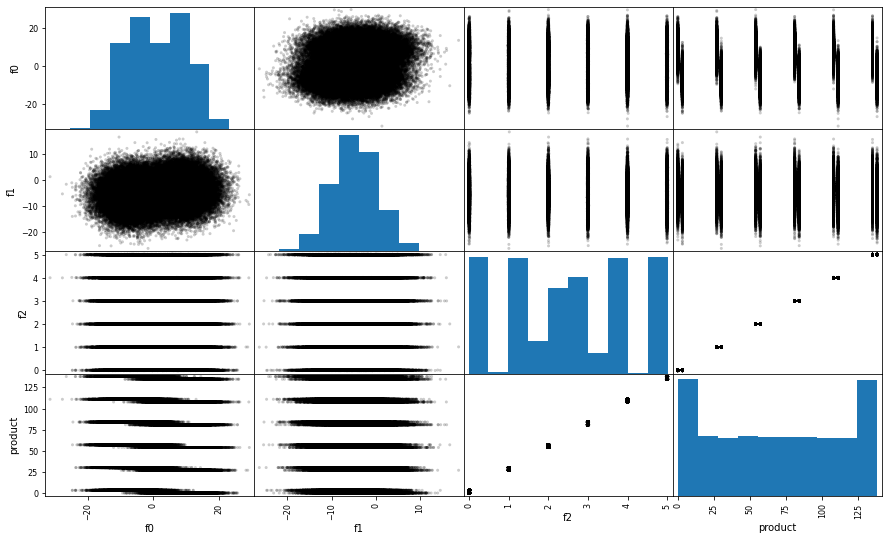

region_2


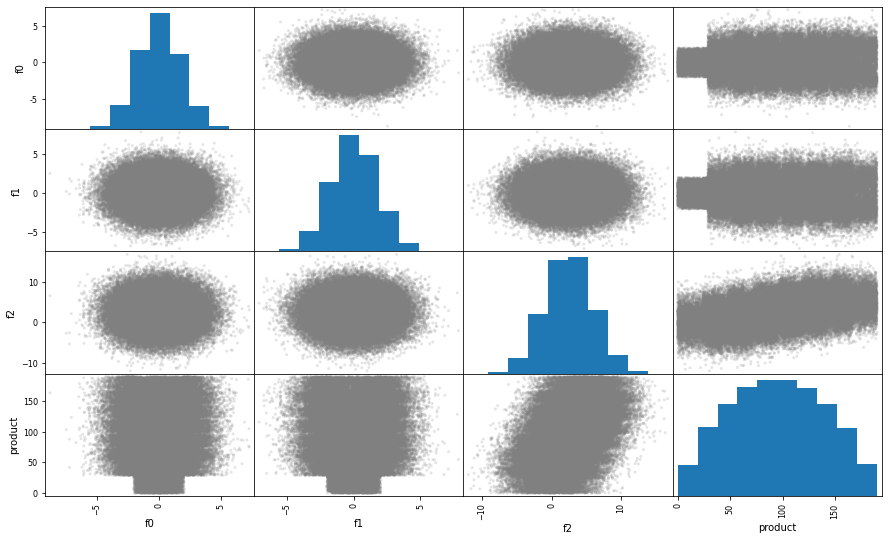

In [7]:
for df, region, color in zip(dfs, list_of_regions, colors):
    print(region)
    pd.plotting.scatter_matrix(df,
                               alpha=0.2,
                               color = color,
                               figsize = (15,9))
    plt.show()

Обнаружена нелинейная зависимость между признаками f0 и f1 в region_0, причём данные также свидетельствуют о неоднородности выборки. Тем не менее, это также не является основанием для исключения признака.

### Вывод:
Мы принимаем для расчёта модели все данные (в данных нет выбросов, нет пропусков, никакие признаки не исключаем).

## Обучение и проверка модели

Разобьём данные на обучающую и валидационную выборки в соотношении 75:25:

In [8]:
X0 = df_0.drop(['id', 'product'], axis=1)
y0 = df_0['product']

X0_train, X0_valid, y0_train, y0_valid = train_test_split(
    X0, y0, test_size=0.25, random_state=23)

print(list_of_regions[0])
print(X0.shape, y0.shape)
print(X0_train.shape, y0_train.shape)
print(X0_valid.shape, y0_valid.shape)



X1 = df_1.drop(['id', 'product'], axis=1)
y1 = df_1['product']

X1_train, X1_valid, y1_train, y1_valid = train_test_split(
    X1, y1, test_size=0.25, random_state=23)

print(list_of_regions[1])
print(X1.shape, y1.shape)
print(X1_train.shape, y1_train.shape)
print(X1_valid.shape, y1_valid.shape)



X2 = df_2.drop(['id', 'product'], axis=1)
y2 = df_2['product']

X2_train, X2_valid, y2_train, y2_valid = train_test_split(
    X2, y2, test_size=0.25, random_state=23)

print(list_of_regions[2])
print(X2.shape, y2.shape)
print(X2_train.shape, y2_train.shape)
print(X2_valid.shape, y2_valid.shape)

region_0
(100000, 3) (100000,)
(75000, 3) (75000,)
(25000, 3) (25000,)
region_1
(100000, 3) (100000,)
(75000, 3) (75000,)
(25000, 3) (25000,)
region_2
(100000, 3) (100000,)
(75000, 3) (75000,)
(25000, 3) (25000,)


В качестве модели нам подходит регрессия, т.к. целевой признак непрерывен. Есть условие в техническом задании о том, что подходит только линейная регрессия. Возьмём её.

In [9]:
model0 = LinearRegression()
model0.fit(X0_train, y0_train)
predictions_valid0 = model0.predict(X0_valid)

model1 = LinearRegression()
model1.fit(X1_train, y1_train)
predictions_valid1 = model1.predict(X1_valid)

model2 = LinearRegression()
model2.fit(X2_train, y2_train)
predictions_valid2 = model2.predict(X2_valid)

results = pd.DataFrame({'metrics': ['RMSE модели линейной регрессии на валидационной выборке',
                                    'Cредний запас предсказанного сырья'],
              list_of_regions[0]: [mean_squared_error(y0_valid, predictions_valid0)**0.5,
                       predictions_valid0.mean()],
              list_of_regions[1]: [mean_squared_error(y1_valid, predictions_valid1)**0.5,
                       predictions_valid1.mean()],
              list_of_regions[2]: [mean_squared_error(y2_valid, predictions_valid2)**0.5,
                       predictions_valid2.mean()]})
results

,metrics,region_0,region_1,region_2
0,RMSE модели линейной регрессии на валидационно...,37.915328,0.890286,40.207422
1,Cредний запас предсказанного сырья,92.818579,68.920538,95.106602


### Вывод:
В регионе region_0 и region_2 запасы выше, но и погрешность полученных результатов выше. Запасы в region_1 ниже в среднем, но и точность модели (из-за высокой корреляции с признаком f2) выше. На данный момент информации недостаточно, чтобы сделать выбор региона. Исключение предикторов из модели как по одному, так и попарно, снижения показателя RMSE не приносит, поэтому ранее мы приняли правильное решение о включении в модель всего объема данных.

## Подготовка к расчёту прибыли

В условиях нам даны несколько ключевых цифр. Сохраним их как константы в Python:

In [10]:
SAMPLE = 500 #количество точек, которое исследуется при разведке
SELECTED_BOREHOLES = 200 #количество точек, которое отбирается из sample для разработки, по наибольшему запасу product
REGION_BUDGET = 10000000000 #бюджет на разработку скважит в каждом регионе
INCOME_PER_1000_BARREL = 450000 #доход с каждой единицы целевого признака product 

Рассчитаем достаточный объем сырья для безубыточной разработки новой скважины:

In [11]:
ENOUGH_OIL_PER_BOREHOLE = round(REGION_BUDGET / SELECTED_BOREHOLES / INCOME_PER_1000_BARREL)
ENOUGH_OIL_PER_BOREHOLE

111

Сравним данный уровень со средними показателями скважин в каждом регионе:

In [12]:
for i, j in zip(dfs, list_of_regions): print('Средний уровень запаса в скважине в регионе', j, round(i['product'].mean()))

Средний уровень запаса в скважине в регионе region_0 93
Средний уровень запаса в скважине в регионе region_1 69
Средний уровень запаса в скважине в регионе region_2 95


### Вывод:
В скважите должно быть более 111 тыс. баррелей нефти, чтобы её разработка имела смысл. Если выбирать точки для разработки случайно, то чаще всего мы будем работать в убыток. Есть смысл в предварительном исследовании и тщательном отборе разрабатываемых скважин.

## Расчёт прибыли и рисков 

Расчитакм прибыль лучших скважин в регионах: 

In [13]:
def profit(predicted, target):
    predicted = pd.Series(predicted).reset_index(drop=True)
    target = pd.Series(target).reset_index(drop=True)
    
    predicted_sort = predicted.sort_values(ascending=False)
    target_sort = target.sort_values(ascending=False)

    oil_quantity_predicted = target[predicted_sort.index][:SELECTED_BOREHOLES].sum()
    oil_quantity_target = target_sort[:SELECTED_BOREHOLES].sum()
    
    predicted_profit = (oil_quantity_predicted * INCOME_PER_1000_BARREL - REGION_BUDGET) / 1000000000
    target_profit = (oil_quantity_target * INCOME_PER_1000_BARREL - REGION_BUDGET) / 1000000000
    
    print('Прогнозная прибыль: {} млрд'.format(round(predicted_profit)))
    print('Фактическая прибыль: {} млрд'.format(round(target_profit)))
    
print(list_of_regions[0])
profit(predictions_valid0, y0_valid)

print(list_of_regions[1])
profit(predictions_valid1, y1_valid)

print(list_of_regions[2])
profit(predictions_valid2, y2_valid)

region_0
Прогнозная прибыль: 3 млрд
Фактическая прибыль: 7 млрд
region_1
Прогнозная прибыль: 2 млрд
Фактическая прибыль: 2 млрд
region_2
Прогнозная прибыль: 3 млрд
Фактическая прибыль: 7 млрд


Качество модели в region_0 и region_2 низкое, поэтому разница в фактическом и прогнозном значении высокая. Но и прибыль в данных регионах выше. 

Приблизим оценки модели к реальности, отобрав самые прибыльные не из всех скважин, а из 500, как это происходит в действительности.

## Выбор региона: 

Изменим ранее написанную функцию так, чтобы она только считала фактическую прибыль от разработки скважин, выбранных с помощью предсказанных значений. Добавим функцию bootstrap, которая позволит рассчитывать прибыль по 10000 раз выбранным 500 скважинам. Количество выборок в процедуре Bootstrap увеличено для получения более стабильного результата, т.к. средние на 1000 выборках при повторном запуске процедуры существенно различались.

In [14]:
def profit(predicted, target):
    predicted = pd.Series(predicted).reset_index(drop=True)
    target = pd.Series(target).reset_index(drop=True)
    
    predicted_sort = predicted.sort_values(ascending=False)

    oil_quantity_target = target[predicted_sort.index][:SELECTED_BOREHOLES].sum()
    
    target_profit = (oil_quantity_target * INCOME_PER_1000_BARREL - REGION_BUDGET) / 1000000000
    
    return target_profit

state = np.random.RandomState(23)

def bootstrap(predicted, target):
    profits = []
    target = target.reset_index(drop=True)
        
    for i in range(10000):
        subsample_target = target.sample(n=500, replace=True, random_state=state)
        subsample_predicted = predicted[subsample_target.index]
        profits.append(profit(subsample_predicted, subsample_target))
        
    return profits

Рассчитаем ключевые показатели для каждого региона:

In [15]:
results = pd.DataFrame({'metrics': ['Средняя прибыль, млрд',
                                    '95% средних лежит в интервале от..., млрд.',
                                   '...до, млрд.',
                                   'Риск убытка'],
              list_of_regions[0]: [round(pd.Series(bootstrap(predictions_valid0, y0_valid)).mean(), 3),
                       round(pd.Series(bootstrap(predictions_valid0, y0_valid)).quantile(.025), 3),
                       round(pd.Series(bootstrap(predictions_valid0, y0_valid)).quantile(.975), 3),
                       round(sum(1 for x in bootstrap(predictions_valid0, y0_valid) if x < 0)/10000, 3)],
                        
              list_of_regions[1]: [round(pd.Series(bootstrap(predictions_valid1, y1_valid)).mean(), 3),
                       round(pd.Series(bootstrap(predictions_valid1, y1_valid)).quantile(.025), 3),
                       round(pd.Series(bootstrap(predictions_valid1, y1_valid)).quantile(.975), 3),
                       round(sum(1 for x in bootstrap(predictions_valid1, y1_valid) if x < 0)/10000, 3)],
                        
              list_of_regions[2]: [round(pd.Series(bootstrap(predictions_valid2, y2_valid)).mean(), 3),
                       round(pd.Series(bootstrap(predictions_valid2, y2_valid)).quantile(.025), 3),
                       round(pd.Series(bootstrap(predictions_valid2, y2_valid)).quantile(.975), 3),
                       round(sum(1 for x in bootstrap(predictions_valid2, y2_valid) if x < 0)/10000, 3)]})
results

,metrics,region_0,region_1,region_2
0,"Средняя прибыль, млрд",0.395,0.472,0.373
1,"95% средних лежит в интервале от..., млрд.",-0.115,0.075,-0.156
2,"...до, млрд.",0.910,0.879,0.890
3,Риск убытка,0.070,0.009,0.086


### Вывод:
Т.к. пороговое значение риска убытка region_0 и region_2 не проходит, остаётся только region_1. Из оставшихся моделей необходимо было сделать выбор по наибольшей прибыли, но данный регион и прибыль показывает наибольшую. Таким образом, всё определяется признаком f2, который позволяет в region_1 максимально точно предсказывать прибыльность скважин и очень точно выбирать из 500 200 самых "богатых". Если удастся подобные данные получить и по другим регионам, то выбор стоит пересмотреть.